<a href="https://colab.research.google.com/github/bogard75/bogard75.github.io/blob/master/naver_stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import

In [0]:
import numpy as np
import pandas as pd
from datetime import datetime

import requests
import threading
import numpy as np
import io
from bs4 import BeautifulSoup
import os

os.chdir('/content/drive/My Drive/Colab Notebooks')
#os.getcwd()

##한글폰트 사용

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


## 함수정의

In [0]:
def naver_sise_time(stock, date):
    print("[%s] %s" % (stock, date))
    
    data = []
    for c in range(1, 50):
        url = "http://finance.naver.com/item/sise_time.nhn?code=%s&thistime=%s160000&page=%s" \
              % (stock, date, c)
        response = requests.get(url)
        soup = BeautifulSoup(response.text.encode('utf-8'), 'html.parser')
        quotes = soup.find_all('span', {'class': ['tah', 'p10']})

        for li in quotes:
            data.append(li.text.strip())
        try:
            if data[-7] == '09:00':
                break
        except:
            pass
        
    # 체결시각 체결가 전일비 매도 매수 거래량 변동량
    if len(data) == 0 :
        r = np.zeros(shape=(1,9))
    else:
        quote = np.reshape(np.array(data), (-1, 7)).tolist()
        r = [[date] + [stock] + i for i in quote]
        r = np.array(r)
    print(r.shape)
    
    return r

# 종목코드
def naver_sise_market_sum():
    d = pd.DataFrame() 
       
    for c in range(1, 50):
        url = "https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=%s" % (c)
        print(url)
        response = requests.get(url)
        soup = BeautifulSoup(response.text.encode('utf-8'), 'html.parser')
        tbl = soup.select('.type_2')[0]
        tbl_rows = tbl.find_all('tr')
        l = []
        for tr in tbl_rows:
            td = tr.find_all('td')
            row = [tr.text.replace('\n','').replace('\t','') for tr in td]
            try:
                stock_code = tr.select('.tltle')[0]['href'].split('=')[1]
                row.insert(1, stock_code)
                l.append(row)
            except:
                pass
            
        try:
            columns = ['N','종목코드','종목명','현재가','전일비','등락률','액면가','시가총액','상장주식수','외국인비율','거래량','PER','ROE','토론방']
            df = pd.DataFrame(l, columns=columns)
            df = df[pd.to_numeric(df.N) > 0].set_index('N').drop(columns='토론방')
            d = d.append(df)
        except:
            pass
        
    return d

##main 실행

In [0]:

if __name__=='__main__':
    # 네이버 코스피 종목코드를 받아서
    stocks = naver_sise_market_sum()
    cols_to_num = ['현재가','전일비','액면가','시가총액','상장주식수','외국인비율','거래량','PER','ROE']
    for c in cols_to_num:
        stocks[c] = stocks[c].str.replace(',','').apply(pd.to_numeric, errors='coerce')
    stocks.to_pickle("./stocks_20200206")

    # 기간동안 거래량을 입수하여
    days = pd.date_range('20200206', '20200206', ).strftime('%Y%m%d')
    r = np.vstack([np.vstack([naver_sise_time(stock=s, date=d) for d in days]) for s in stocks.종목코드])
    
    # 데이터프레임으로 작성함
    columns = ['기준일자','종목코드','체결시각','체결가','전일비','매도','매수','거래량','변동량']
    df = pd.DataFrame(r, columns=columns)
    df = df[df.기준일자.str.len()>=8].reset_index(drop=True)
    cols_to_num = ['체결가','전일비','매도','매수','거래량','변동량']
    for c in cols_to_num:
        df[c] = df[c].str.replace(',','').apply(pd.to_numeric)
    
    # Pickle로 저장
    df.to_pickle("./naver_sise_time_20200206")

https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=1
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=2
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=3
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=4
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=5
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=6
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=7
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=8
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=9
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=10
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=11
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=12
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=13
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=14
https://finance.naver.com/sise/sise_market_sum.nhn?sosok=0&page=15
http

## stocks read (read_pickle)

In [0]:
#stocks.to_csv('stocks.csv')
import pandas as pd

df = pd.read_pickle('stocks_20200210')

cols_to_num = ['현재가','전일비','액면가','시가총액','상장주식수','외국인비율','거래량','PER','ROE']
for c in cols_to_num:
    df[c] = df[c].str.replace(',','').apply(pd.to_numeric, errors='coerce')


In [0]:
import matplotlib.pyplot as plt

X = df['거래량'].map(np.log)
Y = df['현재가'].map(np.log)
C = df['외국인비율']
S = (lambda x : np.log(x/x.max()+1))(df['거래량'])*5000
#color_num = 10

plt.figure(figsize=(50, 50))
plt.scatter(X, Y, c=S, s=C*100, cmap=plt.cm.get_cmap('rainbow'), alpha=0.5)
#plt.scatter(X, Y, c=C, s=S, cmap=plt.cm.get_cmap('rainbow', color_num), alpha=0.5)
plt.colorbar(ticks=range(color_num), format='color: %d', label='color')

for i in range(0, 1500):
    x = X[i]
    y = Y[i]
    anno = df['종목명'][i]
    plt.text(x, y, anno, fontsize=8)
plt.show()


In [21]:
df[df['종목코드']=='090435']

# 기간동안 거래량을 입수하여
r = naver_sise_time(stock='090435', date='20200206')
# 데이터프레임으로 작성함
columns = ['기준일자','종목코드','체결시각','체결가','전일비','매도','매수','거래량','변동량']
df = pd.DataFrame(r, columns=columns)
df = df[df.기준일자.str.len()>=8].reset_index(drop=True)
cols_to_num = ['체결가','전일비','매도','매수','거래량','변동량']
for c in cols_to_num:
    df[c] = df[c].str.replace(',','').apply(pd.to_numeric)


[090435] 20200206
(366, 9)


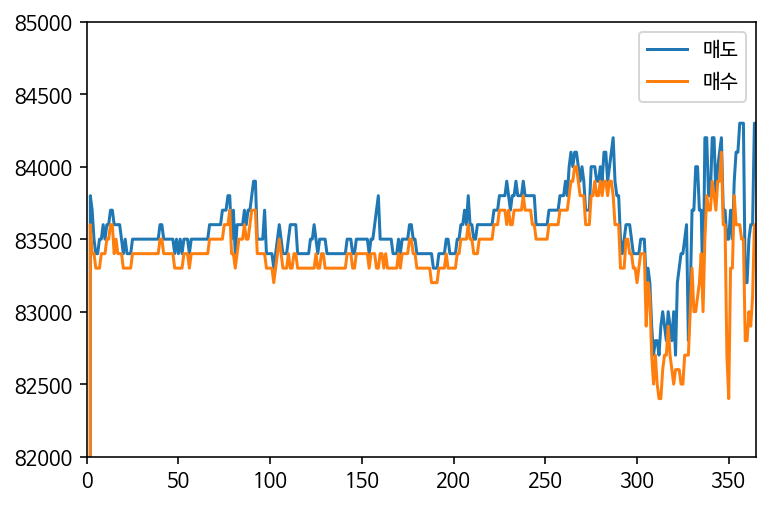

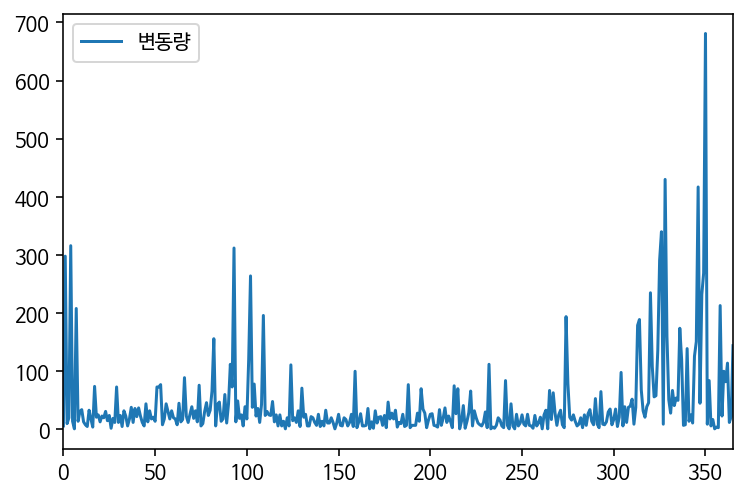

In [34]:
df[['매도','매수']].plot(ylim=(82000,85000))
df[['변동량']].plot()
